<a href="https://colab.research.google.com/github/Varsha-Garikapati/demo-repo/blob/main/01_Detecting_COVID_19_with_Chest_X_Ray_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<strong>
    <h1 align='center'>Detecting COVID-19 with Chest X Ray using PyTorch</h1>
</strong>

---



<p align='center'>
  <a href="#">
    <img src='https://github.com/mohd-faizy/DataScience-Projects/blob/main/Projects_png/09_proj.png?raw=true' alt="covid.png">
  </a>
</p>

__Image classification__ of __Chest X Rays__ in one of __three__ classes:
- __Normal__
- __Viral Pneumonia__
- __COVID-19__

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

## __Task-1__ Downloding the Dataset from Kaggle

In [4]:
# gpu
! nvidia-smi

Sun Nov  2 15:12:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Create api key -> account ->Create New Token
# .json file is genrated

!pip install -q kaggle
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"varru12","key":"7cc4464191ed7813d172aa22c5d33315"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 95% 741M/778M [00:03<00:00, 172MB/s]
100% 778M/778M [00:05<00:00, 161MB/s]


In [7]:
!ls

 covid19-radiography-database.zip   kaggle.json
'kaggle (3).json'		    sample_data


In [8]:
! unzip -uq '/content/covid19-radiography-database.zip' -d '/content/COVID-19_Radiography_Database'

In [9]:
ls

 COVID-19_Radiography_Database/    'kaggle (3).json'   sample_data/
 covid19-radiography-database.zip   kaggle.json


## __Task - 2__ Importing Libraries

In [10]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.8.0+cu126


## __Task - 3__ Preparing Training and Test Sets

In [84]:
root_dir = '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset'
class_names = ['Normal', 'Viral Pneumonia', 'COVID']

for c in class_names:
    class_path = os.path.join(root_dir, c, 'images')  # ✅ Add /images here
    images = [x for x in os.listdir(class_path) if x.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    test_size = int(0.2 * len(images))
    test_images = images[:test_size]

    # ✅ Correct test destination
    test_dir = os.path.join(root_dir, 'test', c)
    os.makedirs(test_dir, exist_ok=True)

    for img in test_images:
        src_path = os.path.join(class_path, img)
        dst_path = os.path.join(test_dir, img)
        shutil.move(src_path, dst_path)


## __Task - 4__ Creating Custom Dataset

In [77]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import random

class ChestXRayDataset(Dataset):
    def __init__(self, image_dirs, transform=None):
        self.image_dirs = image_dirs
        self.transform = transform
        self.class_names = ['normal', 'viral', 'covid']
        self.images = []

        # Load all images from directories
        for class_name in self.class_names:
            class_dir = image_dirs[class_name]
            if not os.path.exists(class_dir):
                print(f"⚠️ Warning: Directory not found for class '{class_name}': {class_dir}")
                continue

            imgs = [os.path.join(class_dir, img)
                    for img in os.listdir(class_dir)
                    if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

            print(f"✅ Found {len(imgs)} {class_name} images")
            self.images += [(img, class_name) for img in imgs]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path, class_name = self.images[index]
        image = Image.open(img_path).convert('RGB')
        label = self.class_names.index(class_name)

        if self.transform:
            image = self.transform(image)

        return image, label


## __Task - 5__ Image Transformations

In [78]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [83]:
!ls /content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/COVID


## __Task - 6__ Prepare DataLoader

In [85]:
train_dirs = {
    'normal': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/Normal/images',
    'viral': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'covid': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/COVID/images'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)


✅ Found 6524 normal images
✅ Found 861 viral images
✅ Found 2893 covid images


In [86]:
test_dirs = {
    'normal': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/Normal',
    'viral': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/Viral Pneumonia',
    'covid': '/content/COVID-19_Radiography_Database/COVID-19_Radiography_Dataset/test/COVID'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)


✅ Found 3668 normal images
✅ Found 484 viral images
✅ Found 723 covid images


In [87]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 1713
Number of test batches 813


## __Task - 7__ Data Visualization

In [88]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

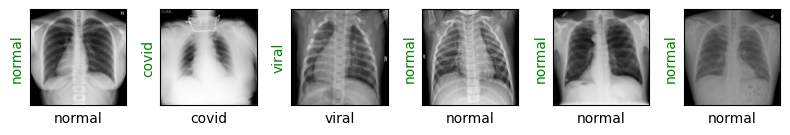

In [89]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

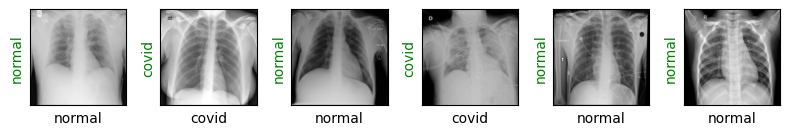

In [90]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## __Task - 8__ Creating the Model

In [91]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [92]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [93]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

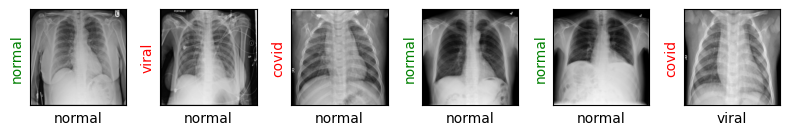

In [94]:
show_preds()

## __Task - 9__ Training the Model

In [95]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.1685, Accuracy: 0.9532


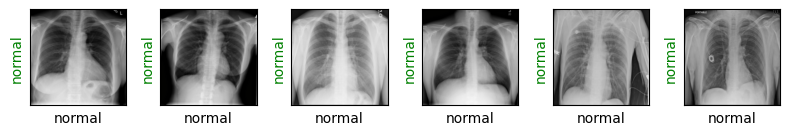

Performance condition satisfied, stopping..
CPU times: user 4min 1s, sys: 2.43 s, total: 4min 3s
Wall time: 4min 9s


In [97]:
%%time

train(epochs=1)

## __Task - 10__ Show the Predictions

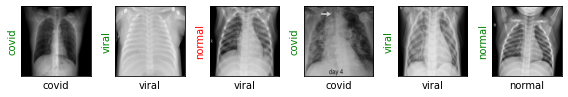

In [ ]:
show_preds()

## __Task - 11__ *Saving* the Model

In [ ]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

## __Task -12__ Inference on a Single Image

In [ ]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

In [ ]:
image_path = '/content/COVID-19_Radiography_Database/COVID-19 Radiography Database/test/viral/Viral Pneumonia (1210).png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [0.01735802 0.9787387  0.00390326]
Predicted class index: 1
Predicted class name: viral
